# AIDM7360 Big Data Management and Analytics Final Progect

- Group name: We are family
- Topic: QS World University ranking
- Group numbers:
HUANG Liang (22465693),
LIANG Xinyi,
CAI Wenxin,
GAO Muxi

## Creating a New Database


In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    
    return conn

In [37]:
fileName = "QS.db"
dbConnection = create_connection(fileName)

It's very important to close the database connections at the end of the operations. This will free resources and allow other programs to connect to the data. To do this use the `close()` method.

Let's create the database connection and execute the two queries

In [3]:
# Create a database connection
fileName = "QS.db"
conn = create_connection(fileName)


## Querying Data

To query data in an SQLite database from Python, you use these steps:

- First, establish a connection to the SQLite database by creating a `Connection` object.
- Next, create a `Cursor` object using the cursor method of the `Connection` object.
- Then, execute a `SELECT` statement.
- After that, call the `fetchall()` method of the `cursor` object to fetch the data.
- Finally, *loop the cursor* and *process each row individually*.

Let's first create a function to select all tasks. We need to create a cursor, execute the SELECT statement, and call the  `fetchall()` to *fetch all tasks from the tasks table*.

In [4]:
## Create view 1 directly, saving the ranking for 2021
query1 = """
create view v1 as
SELECT  `country, city and region`.university, `country, city and region`.country,  `country, city and region`.city, `country, city and region`.region,
`ranking and score`.year,  `ranking and score`.rank_display, `ranking and score`.score
from `ranking and score` 
left join `country, city and region`
on `ranking and score`.university = `country, city and region`.university and `ranking and score`.year= `country, city and region`.year
where `ranking and score`.year  =  2021
and rank_display <= 499
order by `ranking and score`.university, `ranking and score`.year """

cur = conn.cursor()
cur.execute(query1)
conn.commit() ## Write database



In [5]:
## Create view 2 directly, saving the ranking for 2022
query2 = """
create view v2 as
SELECT  `country, city and region`.university, `country, city and region`.country,  `country, city and region`.city, `country, city and region`.region,
`ranking and score`.year,  `ranking and score`.rank_display, `ranking and score`.score
from `ranking and score` 
left join `country, city and region`
on `ranking and score`.university = `country, city and region`.university and `ranking and score`.year= `country, city and region`.year
where `ranking and score`.year  =  2022
and rank_display <= 499
order by `ranking and score`.university, `ranking and score`.year """

cur = conn.cursor()
cur.execute(query2)
conn.commit() ## Write database

In [6]:
## Create view 3 directly, generating the trend variable
query3 = """
create view v3 as
SELECT  v2.university, v2.country,  v2.city, v2.region, v2.year,  v2.rank_display as rank_2022,  v1.rank_display as rank_2021
from v2
left join v1
on v2.university = v1.university 
order by  rank_2022; 
"""
cur = conn.cursor()
cur.execute(query3)
conn.commit() ## Write database

In [7]:
## create view 4 for new column "trend"
query4 = """
create view v4 as
select university, country,  city,  region, year, rank_2021, rank_2022, rank_2021 - rank_2022 as trend
from v3
"""
cur = conn.cursor()
cur.execute(query4)
conn.commit() ## Write database

In [8]:
## Q1 Check the trend of the top 500 schools in 2021-2022
queryq1 = """
select university, country,  city,  region, year,  rank_2021, rank_2022, trend,
case when trend=0 then '--'
      when trend>0 then '↑'
   when trend<0 then '↓'
end trand_sign
from v4
where rank_2022 <= 500
"""
cur = conn.cursor()
cur.execute(queryq1)

#rows = cur.fetchall()
#for row in rows:
    #print(row)

In [9]:
df = pd.read_sql(queryq1, conn)
df.head() ## view top 5 rows

,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign
0,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,2022,1.0,1,0.0,--
1,University of Oxford,United Kingdom,Oxford,Europe,2022,5.0,2,3.0,↑
2,Stanford University,United States,Stanford,North America,2022,2.0,3,-1.0,↓
3,University of Cambridge,United Kingdom,Cambridge,Europe,2022,7.0,3,4.0,↑
4,Harvard University,United States,Cambridge,North America,2022,3.0,5,-2.0,↓


In [10]:
df['change'] = ""

df.head()

,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign,change
0,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,2022,1.0,1,0.0,--,
1,University of Oxford,United Kingdom,Oxford,Europe,2022,5.0,2,3.0,↑,
2,Stanford University,United States,Stanford,North America,2022,2.0,3,-1.0,↓,
3,University of Cambridge,United Kingdom,Cambridge,Europe,2022,7.0,3,4.0,↑,
4,Harvard University,United States,Cambridge,North America,2022,3.0,5,-2.0,↓,


In [11]:
df['trend_abs'] = df['trend'].abs()
df.head()

,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign,change,trend_abs
0,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,2022,1.0,1,0.0,--,,0.0
1,University of Oxford,United Kingdom,Oxford,Europe,2022,5.0,2,3.0,↑,,3.0
2,Stanford University,United States,Stanford,North America,2022,2.0,3,-1.0,↓,,1.0
3,University of Cambridge,United Kingdom,Cambridge,Europe,2022,7.0,3,4.0,↑,,4.0
4,Harvard University,United States,Cambridge,North America,2022,3.0,5,-2.0,↓,,2.0


In [12]:
df.loc[ df["trend"] >=0, 'change']= 'increases'
df.loc[df["trend"] < 0, 'change']= 'decreases'
df.head()

,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign,change,trend_abs
0,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,2022,1.0,1,0.0,--,increases,0.0
1,University of Oxford,United Kingdom,Oxford,Europe,2022,5.0,2,3.0,↑,increases,3.0
2,Stanford University,United States,Stanford,North America,2022,2.0,3,-1.0,↓,decreases,1.0
3,University of Cambridge,United Kingdom,Cambridge,Europe,2022,7.0,3,4.0,↑,increases,4.0
4,Harvard University,United States,Cambridge,North America,2022,3.0,5,-2.0,↓,decreases,2.0


In [13]:
## Enter the school and complete the search
uni = input("Enter University name: ")
df_res = df.loc[df.university==uni]
df_res.reset_index(drop=True, inplace=True)
df_res

Enter University name:Hong Kong Baptist University


,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign,change,trend_abs
0,Hong Kong Baptist University,Hong Kong SAR,Hong Kong,Asia,2022,264.0,287,-23.0,↓,decreases,23.0


In [14]:
# template 1
print(f"{df_res.university[0]}'s QS Ranking in 2022 {df_res.change[0]} {df_res.trend_abs[0]} compared to 2021.")

Hong Kong Baptist University's QS Ranking in 2022 decreases 23.0 compared to 2021.


In [15]:
## Q2 2.The numbers of University from each region in 2021-2022
queryq2 = """
select region, count(university)
from v2
group by region
order by count(university) desc
"""
cur = conn.cursor()
cur.execute(queryq2)

rows = cur.fetchall()
for row in rows:
    print(row)


('Europe', 212)
('Asia', 125)
('North America', 104)
('Oceania', 34)
('Latin America', 21)
('Africa', 5)


In [50]:
reg = input("Enter Region you want to query: ")
v1data_res = v1data.loc[v1data.region==reg]
v1data_res.reset_index(drop=True, inplace=True)
v1data_res

Enter Region you want query: Asia


,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign
0,National University of Singapore (NUS),Singapore,Singapore,Asia,2022,11.0,11,0.0,--
1,"Nanyang Technological University, Singapore (NTU)",Singapore,Singapore,Asia,2022,13.0,12,1.0,↑
2,Tsinghua University,China (Mainland),Beijing,Asia,2022,15.0,17,-2.0,↓
3,Peking University,China (Mainland),Beijing,Asia,2022,23.0,18,5.0,↑
4,The University of Hong Kong,Hong Kong SAR,Hong Kong,Asia,2022,22.0,22,0.0,--
...,...,...,...,...,...,...,...,...,...
120,Auezov South Kazakhstan University (SKU),Kazakhstan,Shymkent,Asia,2022,490.0,482,8.0,↑
121,The Catholic University of Korea,South Korea,Gyeonggi,Asia,2022,456.0,482,-26.0,↓
122,Yokohama City University,Japan,Yokohama City,Asia,2022,465.0,487,-22.0,↓
123,Dongguk University,South Korea,Seoul,Asia,2022,456.0,494,-38.0,↓


In [ ]:
# template 2
print(f"{v1data_res.region[0]} have {} Top 500 Universities in 2022.")

SyntaxError: ignored

In [16]:
# Imports 
import numpy as np 
import pandas as pd 
import re # This module provides regular expression matching 
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [17]:
import pandas as pd
v1data = pd.read_sql(queryq1, conn)
v1data.head() ## view top 5 rows

,university,country,city,region,year,rank_2021,rank_2022,trend,trand_sign
0,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,2022,1.0,1,0.0,--
1,University of Oxford,United Kingdom,Oxford,Europe,2022,5.0,2,3.0,↑
2,Stanford University,United States,Stanford,North America,2022,2.0,3,-1.0,↓
3,University of Cambridge,United Kingdom,Cambridge,Europe,2022,7.0,3,4.0,↑
4,Harvard University,United States,Cambridge,North America,2022,3.0,5,-2.0,↓


In [18]:
region_year_df = v1data[['region','year']].value_counts().reset_index()
region_year_df.columns = ['region','year','sum']
# Check result
region_year_df

,region,year,sum
0,Europe,2022,212
1,Asia,2022,125
2,North America,2022,104
3,Oceania,2022,34
4,Latin America,2022,21
5,Africa,2022,5


In [19]:
fig = px.bar(region_year_df, x="region", y="sum", color="region",
             title="Number of Top 500 QS University from Each Region in 2022")
fig.show()

('The University of Hong Kong', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 22, 22, 0, '--')
('The Hong Kong University of Science and Technology', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 27, 34, -7, '↓')
('The Chinese University of Hong Kong (CUHK)', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 43, 39, 4, '↑')
('City University of Hong Kong', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 48, 53, -5, '↓')
('The Hong Kong Polytechnic University', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 75, 66, 9, '↑')
('Hong Kong Baptist University', 'Hong Kong SAR', 'Hong Kong', 'Asia', 2022, 264, 287, -23, '↓')


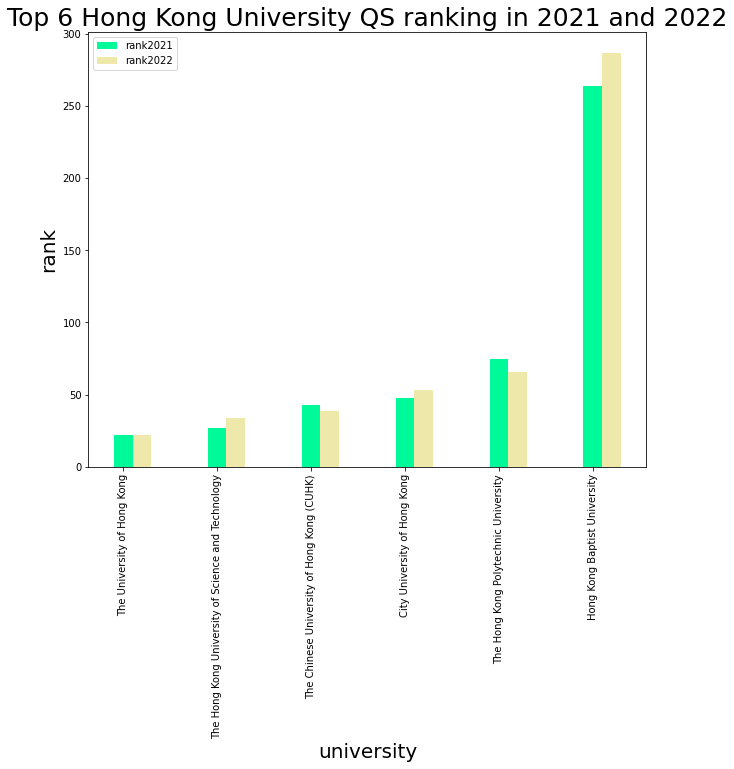

In [22]:
## Q3 3.Top 6 university in Hong Kong ranking changes in 2021-2022

queryq3 = """
select university, country,  city,  region, year,  rank_2021, rank_2022, trend,
case when trend=0 then '--'
      when trend>0 then '↑'
   when trend<0 then '↓'
end trand_sign
from v4
where city = "Hong Kong"
"""
cur = conn.cursor()
cur.execute(queryq3)

rows = cur.fetchall()
labels = []
rank2021_list = []
rank2022_list = []
for row in rows:
    print(row)
    labels.append(row[0])
    rank2021_list.append(row[5])
    rank2022_list.append(row[6])

# print(labels)
# print(rank2021_list)
# print(rank2022_list)
plt.figure(figsize=(10,8)) # set canvas size
ax=plt.axes()

bar_width=0.2  # bar width

ax.bar(labels,rank2021_list,label='rank2021',width=bar_width,align='center',color='#00FA9A')
ax.bar(np.arange(len(labels))+bar_width,rank2022_list,label='rank2022',width=bar_width,align='center',color='#EEE8AA')

ax.set_xticklabels(labels, rotation=90,fontsize=10) 

ax.set_title('Top 6 Hong Kong University QS ranking in 2021 and 2022',fontsize=25)
ax.set_xlabel('university',fontsize=20) 
ax.set_ylabel('rank',fontsize=20)

ax.legend()
plt.show()



In [23]:
## Q4.Distribution of universities across the country/ cities
## Which country or city, contributed the most to the top 500

queryq4_1 = """
select country, count(university)
from v2
group by country
order by count(university) desc
limit 1
"""
cur = conn.cursor()
cur.execute(queryq4_1)

rows = cur.fetchall()

for row in rows:
    print(row)

('United States', 87)


In [24]:
queryq4_2 = """
select city, count(university)
from v2
group by city
order by count(university) desc
limit 2
"""
cur = conn.cursor()
cur.execute(queryq4_2)

rows = cur.fetchall()

for row in rows:
    print(row)

(None, 12)
('London', 10)


In [35]:
country_year_df = v1data[['country','year']].value_counts().reset_index()
country_year_df.columns = ['country','year','sum']
# Check result
country_year_df = country_year_df.head(10)

fig = px.bar(country_year_df, x="country", y="sum", color="country",
             title="Top 10 countries which have the most Top 500 QS University in 2022")
fig.show()

In [36]:
city_year_df = v1data[['city','year']].value_counts().reset_index()
city_year_df.columns = ['city','year','sum']
# Check result
city_year_df = city_year_df.head(10)

fig = px.bar(city_year_df, x="city", y="sum", color="city",
             title="Top 10 cities which have the most Top 500 QS University in 2022")
fig.show()

In [25]:
## Q5.The relation between the Student Faculty Ratio and Research Output
## For all schools in the list for the recent 6 years
queryq5 = """
select * from `research output and student faculty ratio` 
"""

import pandas as pd
df = pd.read_sql(queryq5, conn)
df.head() ## view top 5 rows

,university,year,research_output,student_faculty_ratio
0,Massachusetts Institute of Technology (MIT),2017,Very High,4.0
1,Stanford University,2017,Very High,3.0
2,Harvard University,2017,Very High,5.0
3,University of Cambridge,2017,Very high,4.0
4,California Institute of Technology (Caltech),2017,Very High,2.0


In [26]:
## missing values
df.isnull().sum()

university                0
year                      0
research_output           2
student_faculty_ratio    75
dtype: int64

In [27]:
df.research_output.value_counts()

Very High    4558
High         1424
Medium        424
Low            46
Very high      28
Name: research_output, dtype: int64

In [28]:
df.student_faculty_ratio.describe()

count    6407.000000
mean       13.264554
std         6.604294
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        67.000000
Name: student_faculty_ratio, dtype: float64

In [29]:
df['output'] = df['research_output']
df.head()

,university,year,research_output,student_faculty_ratio,output
0,Massachusetts Institute of Technology (MIT),2017,Very High,4.0,Very High
1,Stanford University,2017,Very High,3.0,Very High
2,Harvard University,2017,Very High,5.0,Very High
3,University of Cambridge,2017,Very high,4.0,Very high
4,California Institute of Technology (Caltech),2017,Very High,2.0,Very High


In [30]:
df.loc[df["research_output"] == "Very High", "output"] = 4
df.loc[df["research_output"] == "Very high", "output"] = 4
df.loc[df["research_output"] == "High", "output"] = 3
df.loc[df["research_output"] == "Medium", "output"] = 2
df.loc[df["research_output"] == "Low", "output"] = 1

In [31]:
df.head()

,university,year,research_output,student_faculty_ratio,output
0,Massachusetts Institute of Technology (MIT),2017,Very High,4.0,4
1,Stanford University,2017,Very High,3.0,4
2,Harvard University,2017,Very High,5.0,4
3,University of Cambridge,2017,Very high,4.0,4
4,California Institute of Technology (Caltech),2017,Very High,2.0,4


In [32]:
df['output'] = pd.to_numeric(df.output)
df.head()

,university,year,research_output,student_faculty_ratio,output
0,Massachusetts Institute of Technology (MIT),2017,Very High,4.0,4.0
1,Stanford University,2017,Very High,3.0,4.0
2,Harvard University,2017,Very High,5.0,4.0
3,University of Cambridge,2017,Very high,4.0,4.0
4,California Institute of Technology (Caltech),2017,Very High,2.0,4.0


In [33]:
df
df.corr() ## Pearson coorelation， -0.183038

,year,student_faculty_ratio,output
year,1.000000,0.037796,-0.083973
student_faculty_ratio,0.037796,1.000000,-0.183038
output,-0.083973,-0.183038,1.000000


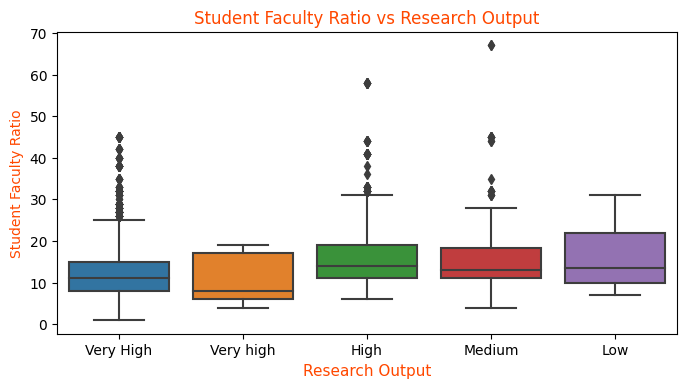

In [34]:
plt.figure(figsize=(8,4), dpi=100)
sns.boxplot(data=df, y='student_faculty_ratio', x='research_output');
plt.xlabel('Research Output', fontsize=11, color = '#ff4800')
plt.ylabel('Student Faculty Ratio',color = '#ff4800')
plt.title('Student Faculty Ratio vs Research Output', color = '#ff4800');